In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
import zipfile
local_zip = '/content/drive/MyDrive/ML Project/cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/extracted')
zip_ref.close()

In [3]:
train_csv = pd.read_csv("/content/extracted/cats_and_dogs/train/classes_train.csv")
test_csv = pd.read_csv("/content/extracted/cats_and_dogs/test/classes_test.csv")
valid_csv = pd.read_csv("/content/extracted/cats_and_dogs/valid/classes_valid.csv")

In [4]:
train_dog = train_csv.loc[train_csv.dog == 1]
train_cat = train_csv.loc[train_csv.cat == 1]
valid_dog = valid_csv.loc[valid_csv.dog == 1]
valid_cat = valid_csv.loc[valid_csv.cat == 1]

In [5]:
import os
os.mkdir('/content/train')
os.mkdir('/content/valid')
os.mkdir('/content/train/dog')
os.mkdir('/content/train/cat')
os.mkdir('/content/valid/dog')
os.mkdir('/content/valid/cat')

In [6]:
train_dog_list=[]
train_cat_list=[]
valid_dog_list=[]
valid_cat_list=[]
for i in train_dog.filename:
  train_dog_list.append(i)
for i in train_cat.filename:
  train_cat_list.append(i)
for i in valid_dog.filename:
  valid_dog_list.append(i)
for i in valid_cat.filename:
  valid_cat_list.append(i)
  

In [7]:
src = "/content/extracted/cats_and_dogs/train"
dst = "/content/train/dog"
for image in os.listdir('/content/extracted/cats_and_dogs/train'):
  if image in train_dog_list and image.endswith(".jpg"):
    src_path = os.path.join(src,image)
    dst_path = os.path.join(dst,image)
    os.rename(src_path, dst_path)

In [8]:
src = "/content/extracted/cats_and_dogs/train"
dst = "/content/train/cat"
for image in os.listdir('/content/extracted/cats_and_dogs/train'):
  if image in train_cat_list and image.endswith(".jpg"):
    src_path = os.path.join(src,image)
    dst_path = os.path.join(dst,image)
    os.rename(src_path, dst_path)

In [9]:
src = "/content/extracted/cats_and_dogs/valid"
dst = "/content/valid/cat"
for image in os.listdir('/content/extracted/cats_and_dogs/valid'):
  if image in valid_cat_list and image.endswith(".jpg"):
    src_path = os.path.join(src,image)
    dst_path = os.path.join(dst,image)
    os.rename(src_path, dst_path)

In [10]:
src = "/content/extracted/cats_and_dogs/valid"
dst = "/content/valid/dog"
for image in os.listdir('/content/extracted/cats_and_dogs/valid'):
  if image in valid_dog_list and image.endswith(".jpg"):
    src_path = os.path.join(src,image)
    dst_path = os.path.join(dst,image)
    os.rename(src_path, dst_path)

In [11]:
image_size = (180, 180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "valid",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2576 files belonging to 2 classes.
Found 736 files belonging to 2 classes.


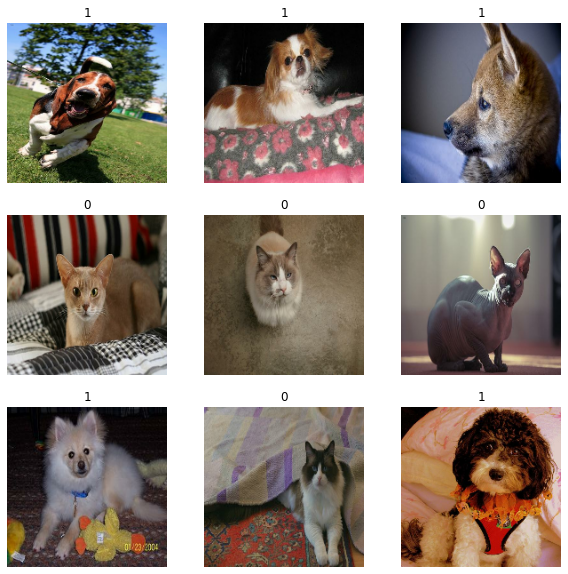

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.5),])

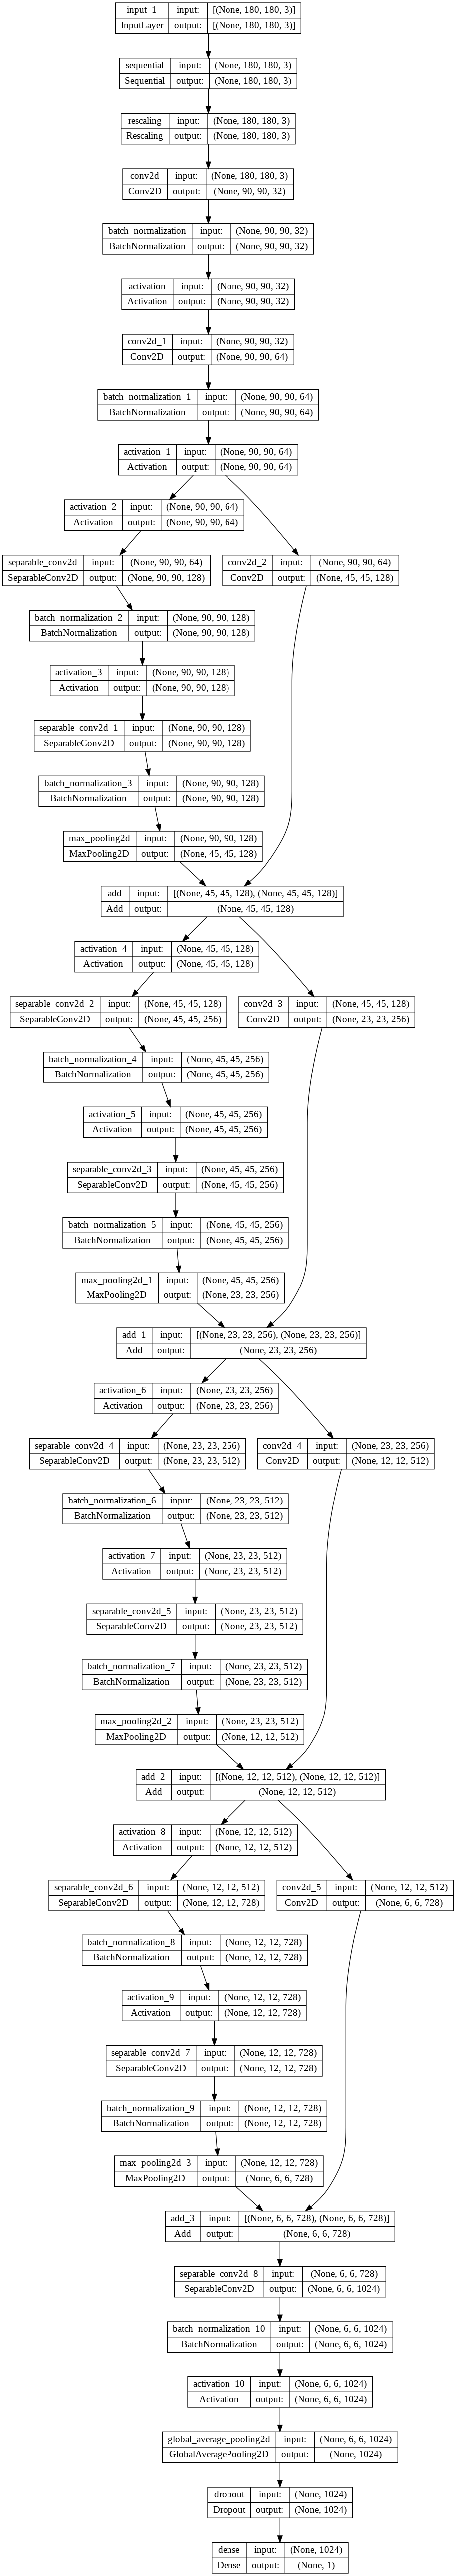

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x=data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [15]:
epochs = 25
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model.compile(optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],)
model_fit_data = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,)

Epoch 1/25
81/81 [==============================] - 39s 316ms/step - loss: 0.6671 - accuracy: 0.6491 - val_loss: 0.6940 - val_accuracy: 0.3465
Epoch 2/25
81/81 [==============================] - 25s 309ms/step - loss: 0.6277 - accuracy: 0.6685 - val_loss: 0.6401 - val_accuracy: 0.6617
Epoch 3/25
81/81 [==============================] - 25s 305ms/step - loss: 0.6080 - accuracy: 0.6813 - val_loss: 0.6480 - val_accuracy: 0.6617
Epoch 4/25
81/81 [==============================] - 25s 302ms/step - loss: 0.5853 - accuracy: 0.6960 - val_loss: 0.6487 - val_accuracy: 0.6617
Epoch 5/25
81/81 [==============================] - 25s 301ms/step - loss: 0.5612 - accuracy: 0.7166 - val_loss: 0.6296 - val_accuracy: 0.6617
Epoch 6/25
81/81 [==============================] - 25s 301ms/step - loss: 0.5523 - accuracy: 0.7236 - val_loss: 0.7295 - val_accuracy: 0.3682
Epoch 7/25
81/81 [==============================] - 25s 301ms/step - loss: 0.5231 - accuracy: 0.7473 - val_loss: 0.7435 - val_accuracy: 0.5054

In [19]:
score_list=[]
path="/content/extracted/cats_and_dogs/test/"
for image in os.listdir("/content/extracted/cats_and_dogs/test"):
  if image.endswith(".jpg"):
    img = keras.preprocessing.image.load_img(path+image, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score))
    score_list.append(score)

1/1 [==============================] - 1s 983ms/step
This image is 2.58 percent cat and 97.42 percent dog.
1/1 [==============================] - 0s 49ms/step
This image is 60.53 percent cat and 39.47 percent dog.
1/1 [==============================] - 0s 31ms/step
This image is 62.35 percent cat and 37.65 percent dog.
1/1 [==============================] - 0s 25ms/step
This image is 97.71 percent cat and 2.29 percent dog.
1/1 [==============================] - 0s 24ms/step
This image is 0.08 percent cat and 99.92 percent dog.
1/1 [==============================] - 0s 33ms/step
This image is 59.36 percent cat and 40.64 percent dog.
1/1 [==============================] - 0s 22ms/step
This image is 80.72 percent cat and 19.28 percent dog.
1/1 [==============================] - 0s 15ms/step
This image is 53.01 percent cat and 46.99 percent dog.
1/1 [==============================] - 0s 16ms/step
This image is 9.23 percent cat and 90.77 percent dog.
1/1 [==============================] - 0

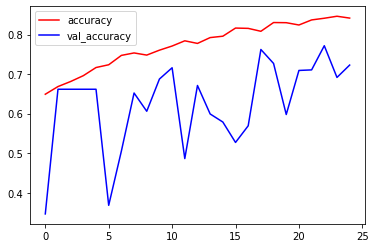

In [21]:
plt.plot(model_fit_data.history['accuracy'],c='red',label='accuracy')
plt.plot(model_fit_data.history['val_accuracy'],c='blue',label='val_accuracy')
plt.legend()
plt.show()